# Project - House prices prediction

## Load Packages

In [261]:
import numpy as np
import pandas as pd
import random
import sys
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.cluster import KMeans,AgglomerativeClustering

from scipy.stats import norm
from scipy import stats

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

## Datasets directory

In [262]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

## Load Datasets

In [263]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
print(f'Train:\t{train.shape[0]}\t sales and {train.shape[1]} features')
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [264]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [265]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


## Type Conversion

In [266]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [267]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [268]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

## Optimization function

In [269]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

In [270]:
print(f'Before size of Train is {sys.getsizeof(train)} bytes')
print(f'Before size of test is {sys.getsizeof(test)} bytes')

Before size of Train is 3100144 bytes
Before size of test is 1510144 bytes


In [271]:
train = optimizing_df(train)
test = optimizing_df(test)

In [272]:
print(f'Now size of Train is {sys.getsizeof(train)} bytes')
print(f'Now size of test is {sys.getsizeof(test)} bytes')

Now size of Train is 430816 bytes
Now size of test is 185816 bytes


## EDA

Text(0.5, 1.0, 'Target distribution')

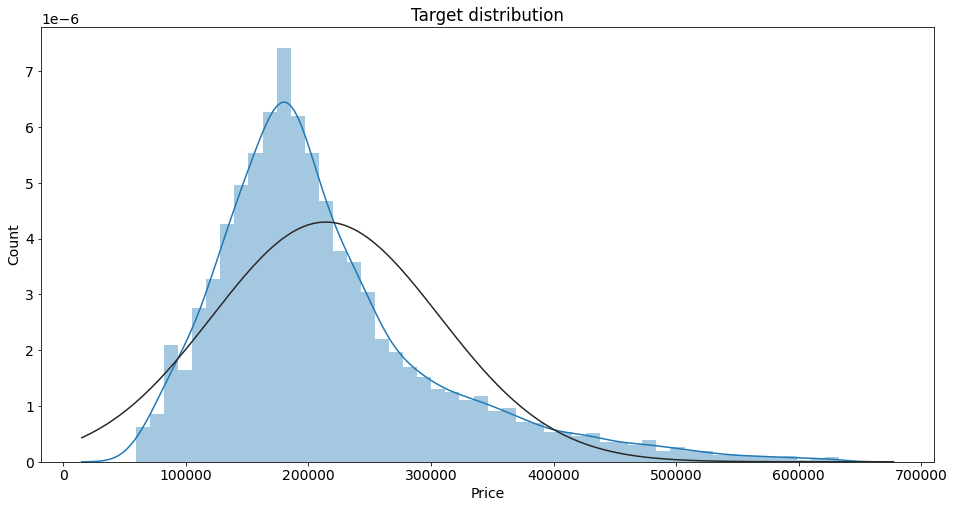

In [273]:
plt.figure(figsize = (16, 8))

sns.distplot(train['Price'], fit=norm)

plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')

In [274]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [275]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [276]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [277]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [278]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Data Checking

In [279]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [280]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360352,20.423912,1.136859,41.814370,52.645758,66.036606,6.410652e+02
LifeSquare,11846.0,36.851791,71.120186,0.333490,22.896130,32.822811,45.144627,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218670e-01


#### Delete outliers from data : ROOMS

In [281]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
13398,1435,111,17,52.866108,32.528343,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [282]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
12406,3343,58,0,116.824203,113.692421,0.0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
12524,10729,27,0,76.345154,42.820797,12.0,14,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [283]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

#### Delete outliers from data : SQUARE

In [284]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
13217,4058,27,6,223.453690,104.113556,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
13909,1397,76,3,221.138763,118.055344,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4,200.334534,201.627365,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


mu = 56.36 and sigma = 20.42


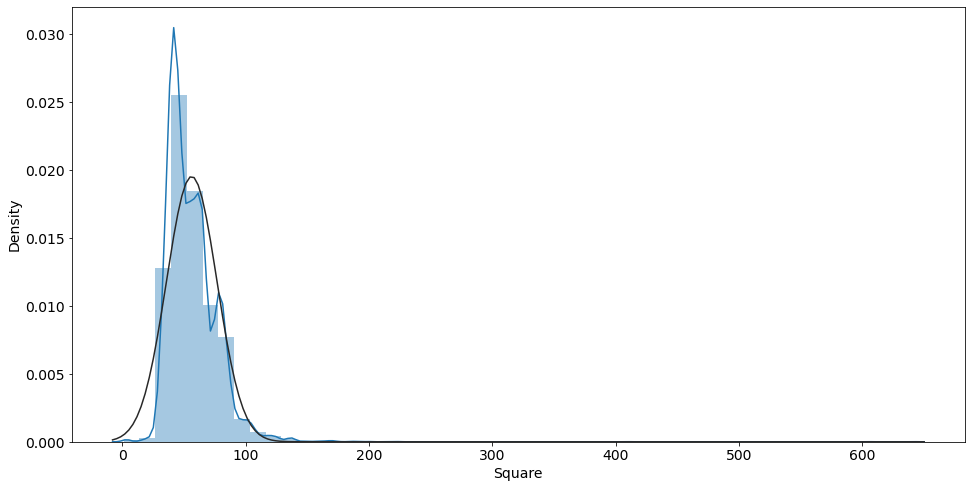

In [285]:
plt.figure(figsize = (16, 8))

sns.distplot(all_data['Square'], fit=norm)
mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

In [286]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [287]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [288]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

#### Delete outliers from data : HOUSEYEAR

In [289]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [290]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

#### Processing of missing data

In [291]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [292]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,21.026667


In [293]:
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

## Data Processing

#### Data Correlation

<AxesSubplot:>

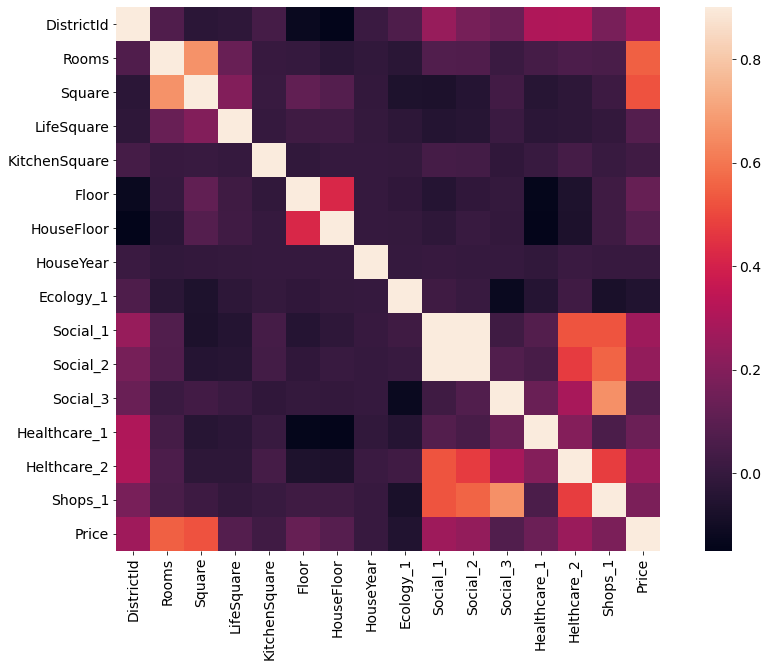

In [294]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize = (16, 10))
sns.heatmap(corrmat, vmax=0.9, square=True)

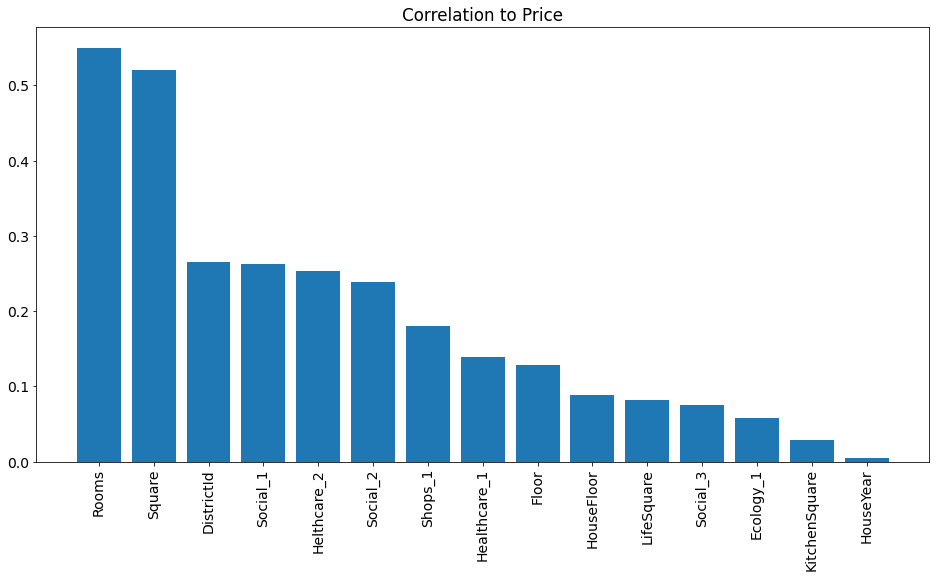

In [295]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.figure(figsize = (16, 8))
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [296]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [297]:
scaler = MinMaxScaler()

train_cluster = train.copy()

train_cluster = df_fix_house_year_manual(train_cluster)

train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

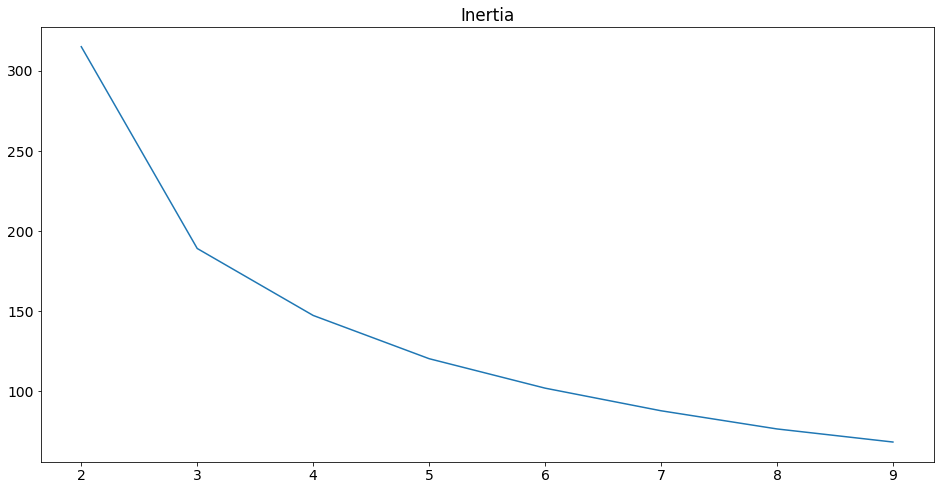

In [298]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)
    
plt.figure(figsize = (16, 8))

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

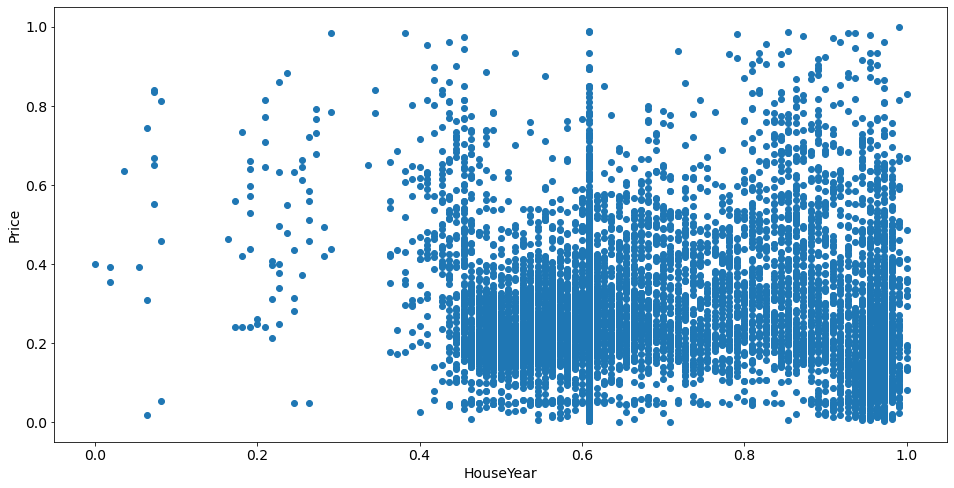

In [299]:
plt.figure(figsize = (16, 8))
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

Text(0.5, 1.0, 'Train data')

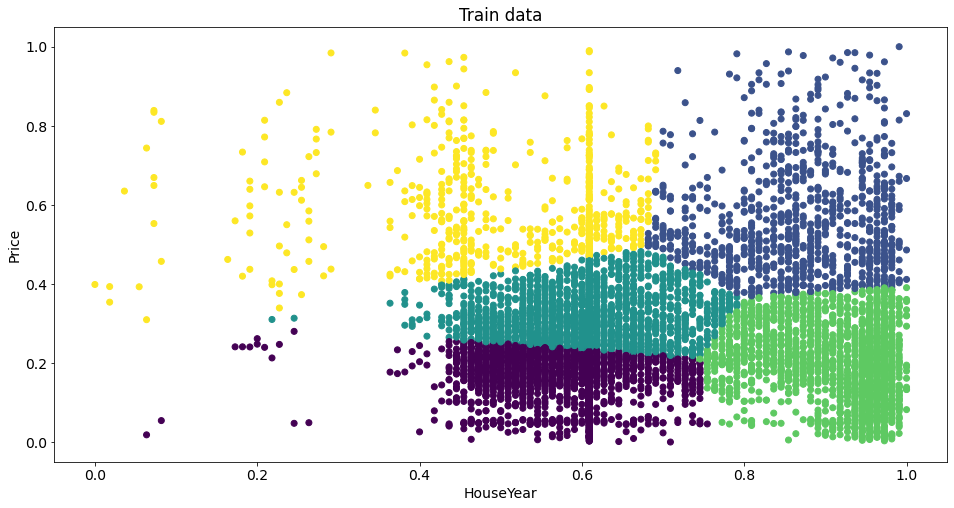

In [300]:
kmeans_model = KMeans(n_clusters=5, random_state=100)
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

plt.figure(figsize = (16, 8))

plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

Text(0.5, 1.0, 'Train')

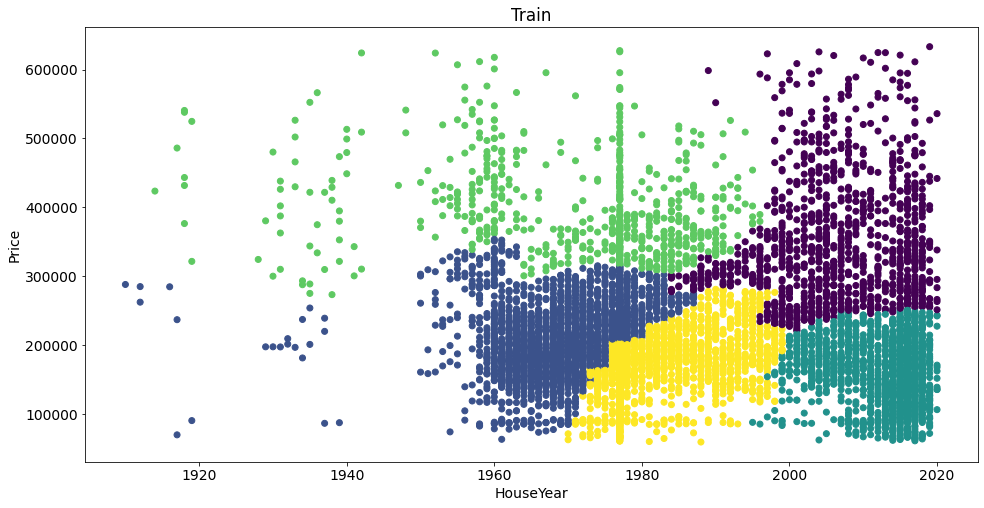

In [301]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

plt.figure(figsize = (16, 8))

plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [302]:
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

#### Mean price by Rooms and Mean price by DistrictId and Rooms

In [303]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

#### Large district

In [304]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df


In [317]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.figure(figsize = (16, 8))
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

In [318]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [319]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear
0,2,47.981560,35,33,0,7976,11,NaN,7,9,29.442751,5,0.089040,6.0,1969
1,3,65.683640,41,46,1,10309,16,240.0,7,9,40.049541,1,0.000070,8.0,1978
2,2,44.947952,53,34,1,7759,3,229.0,8,12,29.197611,0,0.049637,0.0,1968
3,2,53.352982,58,23,0,5735,5,1084.0,8,17,52.731510,3,0.437885,9.0,1977
4,1,39.649193,99,35,2,5776,4,2078.0,11,12,23.776169,1,0.012339,7.0,1976


In [320]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [321]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

In [322]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                7000 non-null   uint8  
 1   Square               7000 non-null   float32
 2   DistrictId           7000 non-null   uint8  
 3   Social_1             7000 non-null   uint8  
 4   Helthcare_2          7000 non-null   uint8  
 5   Social_2             7000 non-null   uint16 
 6   Shops_1              7000 non-null   uint8  
 7   Floor                7000 non-null   uint8  
 8   HouseFloor           7000 non-null   uint8  
 9   LifeSquare           7000 non-null   float32
 10  Social_3             7000 non-null   uint8  
 11  Ecology_1            7000 non-null   float32
 12  KitchenSquare        7000 non-null   float32
 13  HouseYear            7000 non-null   uint16 
 14  cluster_year         7000 non-null   uint8  
 15  mean_price_dr        7000 non-null   f

In [323]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                3000 non-null   uint8  
 1   Square               3000 non-null   float32
 2   DistrictId           3000 non-null   uint8  
 3   Social_1             3000 non-null   uint8  
 4   Helthcare_2          3000 non-null   uint8  
 5   Social_2             3000 non-null   uint16 
 6   Shops_1              3000 non-null   uint8  
 7   Floor                3000 non-null   uint8  
 8   HouseFloor           3000 non-null   uint8  
 9   LifeSquare           3000 non-null   float32
 10  Social_3             3000 non-null   uint8  
 11  Ecology_1            3000 non-null   float32
 12  KitchenSquare        3000 non-null   float32
 13  HouseYear            3000 non-null   uint16 
 14  cluster_year         3000 non-null   uint8  
 15  mean_price_dr        3000 non-null   f

In [324]:
X_train.head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district
0,1,41.681381,23,6,0,1437,2,14,17,22.796165,3,0.075779,8.0,2015,1,100961.812500,159850.796875,394
1,3,101.102737,23,2,0,475,0,5,3,101.102737,0,0.014073,12.0,1977,4,170912.203125,289337.968750,394
2,1,39.710133,87,43,1,7227,6,4,17,19.538664,0,0.100456,8.0,1986,2,173074.250000,159850.796875,21
3,3,96.056786,48,46,1,9515,10,15,1,96.056786,5,0.041125,1.0,2017,1,398124.250000,289337.968750,62
4,3,79.195824,77,16,1,4048,3,16,17,44.421062,3,0.298205,10.0,1984,2,250388.140625,289337.968750,28


In [325]:
y_train.head()

9069     88504.382812
2603    207007.953125
7738    182126.281250
1579    524365.562500
5058    322048.437500
Name: Price, dtype: float32

## Building a model

#### Gradient Boosting Regressor - (4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта)

In [326]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [332]:
models_dict = {}

In [333]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

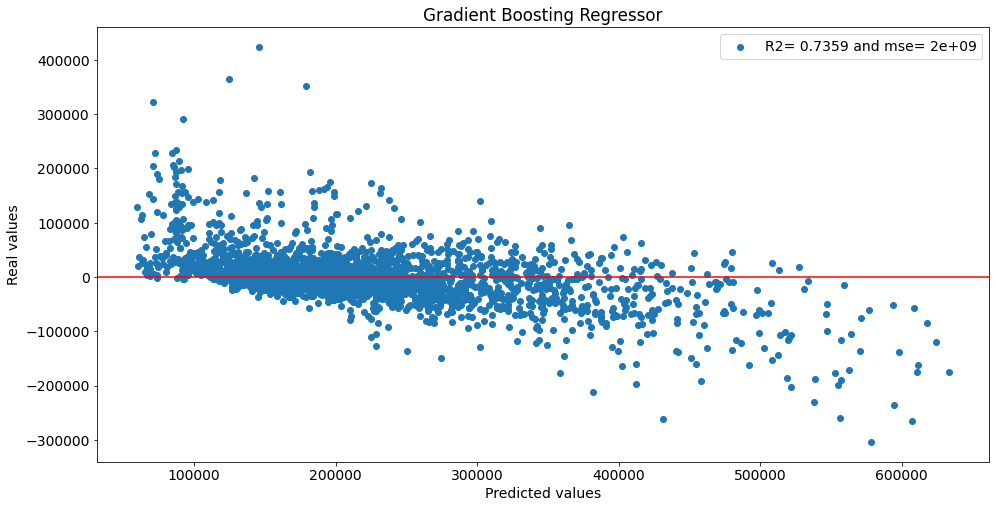

In [327]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

In [329]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

In [334]:
models_score_test = models_r2(models_dict, X_test, y_test)

In [336]:
models_score_test[['name', 'r2']]

,name,r2
0,Gradient Boosting Regressor,0.735923


In [339]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(models_dict['Gradient Boosting Regressor'].feature_importances_)})

,name,importances
0,Rooms,0.000763
1,Square,0.122040
2,DistrictId,0.003039
3,Social_1,0.012511
4,Helthcare_2,0.000068
5,Social_2,0.000990
6,Shops_1,0.001298
7,Floor,0.009914
8,HouseFloor,0.008489
9,LifeSquare,0.003053


In [341]:
test = data_prepare(test)

In [342]:
test_features = list(X_train.columns)

In [343]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   uint8  
 1   Square               5000 non-null   float32
 2   DistrictId           5000 non-null   uint8  
 3   Social_1             5000 non-null   uint8  
 4   Helthcare_2          5000 non-null   uint8  
 5   Social_2             5000 non-null   uint16 
 6   Shops_1              5000 non-null   uint8  
 7   Floor                5000 non-null   uint8  
 8   HouseFloor           5000 non-null   uint8  
 9   LifeSquare           5000 non-null   float32
 10  Social_3             5000 non-null   uint8  
 11  Ecology_1            5000 non-null   float32
 12  KitchenSquare        5000 non-null   float32
 13  HouseYear            5000 non-null   uint16 
 14  cluster_year         5000 non-null   uint8  
 15  mean_price_dr        5000 non-null   f

In [344]:
test['Price'] = models_dict['Gradient Boosting Regressor'].predict(test[test_features])

In [345]:
test[['Id', 'Price']].to_csv('MyPredictions.csv', index=None)